In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from tsfresh import feature_extraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, precision_score, recall_score


from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import NPYBoschCNCDataLoader, SimpleTSFreshBoschCNCDataloader
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples, extract_tsfresh_features

In [3]:
baseline_loader = SimpleTSFreshBoschCNCDataloader(
    metadata_path="/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/metadata_ws4096.pkl"
)
baseline_loader.load_data("/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/all_top_30_features.pkl", 
"/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/sample_data_y_raw_ws4096.npy")

In [4]:
baseline_loader.generate_datasets_by_size(train_size=.4,val_size=.1,test_size=.5, processes=["OP07"])

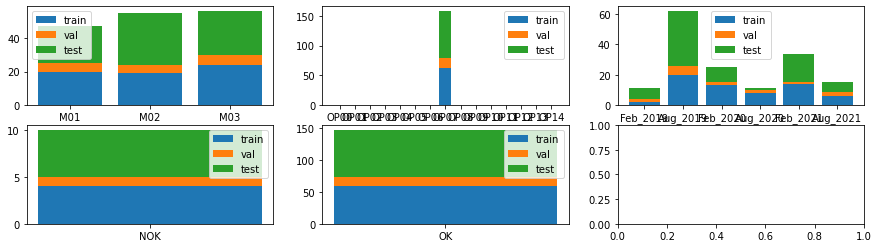

In [5]:
baseline_loader.plot_stats()

In [6]:
X_train = baseline_loader.sample_data_X.iloc[baseline_loader.train_sample_ids].to_numpy()
y_train = baseline_loader.sample_data_y[baseline_loader.train_sample_ids]

X_val = baseline_loader.sample_data_X.iloc[baseline_loader.val_sample_ids].to_numpy()
y_val = baseline_loader.sample_data_y[baseline_loader.val_sample_ids]

X_test = baseline_loader.sample_data_X.iloc[baseline_loader.test_sample_ids].to_numpy()
y_test = baseline_loader.sample_data_y[baseline_loader.test_sample_ids]

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

print("Training Set")
print(classification_report(y_train, y_pred_train, target_names=["OK", "NOK"]))
print("Validation Set")
print(classification_report(y_val, y_pred_val, target_names=["OK", "NOK"]))
print("Test Set")
print(classification_report(y_test, y_pred_test, target_names=["OK", "NOK"]))

Training Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       702
         NOK       1.00      1.00      1.00        33

    accuracy                           1.00       735
   macro avg       1.00      1.00      1.00       735
weighted avg       1.00      1.00      1.00       735

Validation Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       177
         NOK       1.00      1.00      1.00         9

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

Test Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       878
         NOK       1.00      0.98      0.99        45

    accuracy                           1.00       923
   macro avg       1.00      0.99      0.99       923
weighted avg       1.00      1.00    

In [9]:
angles = []
f1_scores = []
confidences = []

augmented_features_basepath = "/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/raw_data/augmented"
for angle in np.arange(0.0, 60.0, 5.0):
    angle_f1_scores = []
    angle_confidences = []
    for axis in ["yaw", "pitch", "roll", "all"]:
        if angle == 0.0:
            X_test = baseline_loader.sample_data_X.iloc[baseline_loader.test_sample_ids].to_numpy()
            y_test = baseline_loader.sample_data_y[baseline_loader.test_sample_ids]
            y_pred_test = model.predict(X_test)
            avg_conf = np.mean(np.max(model.predict_proba(X_test), axis=-1))
        else:
            augmented_features_filename = f"tsfresh_top30_{axis}_shift_{angle}_deg.pkl"
            augmented_features_filepath = os.path.join(augmented_features_basepath, augmented_features_filename)
            
            augmented_loader = SimpleTSFreshBoschCNCDataloader(
                metadata_path="/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/metadata_ws4096.pkl"
            )
            augmented_loader.load_data(augmented_features_filepath, 
            "/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/sample_data_y_raw_ws4096.npy")

            X_test = augmented_loader.sample_data_X.iloc[baseline_loader.test_sample_ids][baseline_loader.sample_data_X.columns].to_numpy()
            y_test = augmented_loader.sample_data_y[baseline_loader.test_sample_ids]
            y_pred_test = model.predict(X_test)
            avg_conf = np.mean(np.max(model.predict_proba(X_test), axis=-1))
            # print(f"Test set results for {angle} degrees shift in {axis}:")
            # print(classification_report(y_test, y_pred_test, target_names=["OK", "NOK"]))
        
        angle_f1_scores.append(f1_score(y_test, y_pred_test))
        angle_confidences.append(avg_conf)

    angles.append(angle)
    f1_scores.append(angle_f1_scores)
    confidences.append(angle_confidences)

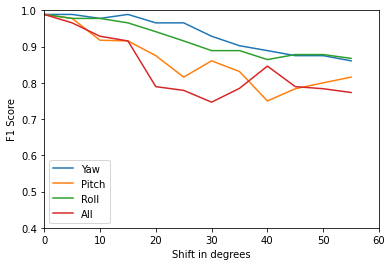

In [11]:
plt.plot(angles, np.array(f1_scores), label=["Yaw", "Pitch", "Roll", "All"])
plt.xlim([0, 60])
plt.ylim([0.4, 1.0])
plt.xlabel("Shift in degrees")
plt.ylabel("F1 Score")
plt.legend()
plt.show()